#Install needed libraries

In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

path = "/content/gdrive/MyDrive/Chuyên đề nghiên cứu 1/"
%cd {path}
!ls

Mounted at /content/gdrive
/content/gdrive/MyDrive/Chuyên đề nghiên cứu 1


In [2]:
!git clone https://github.com/phamdinhkhanh/vnquant
%cd vnquant
!python setup.py install

Cloning into 'vnquant'...
remote: Enumerating objects: 341, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 341 (delta 65), reused 89 (delta 53), pack-reused 237
Receiving objects: 100% (341/341), 1.05 MiB | 7.53 MiB/s, done.
Resolving deltas: 100% (164/164), done.
/content/gdrive/MyDrive/Chuyên đề nghiên cứu 1/vnquant
running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/

In [3]:
%cd ..
!rm -rf vnquant
!ls

/content/gdrive/MyDrive/Chuyên đề nghiên cứu 1


In [4]:
!pip freeze | grep vnquant

vnquant==0.1.1


In [1]:
import vnquant
vnquant.__version__

'0.1.1'

In [2]:
!pip install plotly
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.9 MB/s eta 0:00:00


In [3]:
import vnquant.data as dt
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima, ndiffs
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score

#We choose 10 codes from biggest companies on stock exchange in Vietnam

In [4]:
stock_symbols = ['VIC', 'VCB', 'VNM', 'GAS', 'HVN', 'MWG', 'FPT', 'HPG', 'MSN', 'SAB']
print(stock_symbols)

['VIC', 'VCB', 'VNM', 'GAS', 'HVN', 'MWG', 'FPT', 'HPG', 'MSN', 'SAB']


#Prepare the dataset

In [5]:
stock_data = {}
for i in range(len(stock_symbols)):
  data = dt.DataLoader(symbols=stock_symbols[i],
                        start="2014-01-01",
                        end="2024-01-01",
                        data_source="VND")
  stock_data[stock_symbols[i]] = data.download()

In [6]:
stock_data[stock_symbols[0]]

Attributes,high,low,open,close,avg,volume
Symbols,VIC,VIC,VIC,VIC,VIC,VIC
date,,,,,,
2014-01-02,70.50,69.50,70.00,70.00,69.92,74950.0
2014-01-03,70.50,69.50,70.00,70.50,70.00,91920.0
2014-01-06,70.50,69.50,70.50,70.50,70.11,111760.0
2014-01-07,70.50,70.00,70.50,70.50,70.47,294120.0
2014-01-08,70.50,70.00,70.00,70.00,70.02,109890.0
...,...,...,...,...,...,...
2023-12-25,43.55,43.00,43.10,43.40,43.34,3364500.0
2023-12-26,43.75,43.35,43.40,43.55,43.55,1806700.0


In [7]:
for i in range(len(stock_symbols)):
  print(f"Length of {stock_symbols[i]} with index {i}: ", len(stock_data[stock_symbols[i]]))

Length of VIC with index 0:  2494
Length of VCB with index 1:  2494
Length of VNM with index 2:  2494
Length of GAS with index 3:  2494
Length of HVN with index 4:  1743
Length of MWG with index 5:  2368
Length of FPT with index 6:  2494
Length of HPG with index 7:  2494
Length of MSN with index 8:  2494
Length of SAB with index 9:  1767


In [8]:
changed_start_index5 = len(stock_data[stock_symbols[5]]) - len(stock_data[stock_symbols[4]])
stock_data[stock_symbols[5]] = stock_data[stock_symbols[5]][changed_start_index5:]

In [9]:
changed_start_index9 = len(stock_data[stock_symbols[9]]) - len(stock_data[stock_symbols[4]])
stock_data[stock_symbols[9]] = stock_data[stock_symbols[9]][changed_start_index9:]

In [10]:
changed_start_other_index = len(stock_data[stock_symbols[0]]) - len(stock_data[stock_symbols[4]])
for i in range(len(stock_symbols)):
  if ((i == 4) or (i == 5) or (i == 9)):
    pass
  else:
    stock_data[stock_symbols[i]] = stock_data[stock_symbols[i]][changed_start_other_index:]

In [11]:
combined_close = (stock_data[stock_symbols[0]]['close'].values + stock_data[stock_symbols[1]]['close'].values + stock_data[stock_symbols[2]]['close'].values +
                 stock_data[stock_symbols[3]]['close'].values + stock_data[stock_symbols[4]]['close'].values + stock_data[stock_symbols[5]]['close'].values +
                 stock_data[stock_symbols[6]]['close'].values + stock_data[stock_symbols[7]]['close'].values + stock_data[stock_symbols[8]]['close'].values +
                 stock_data[stock_symbols[9]]['close'].values) / len(stock_symbols)
combined_close

array([[82.185],
       [83.725],
       [84.06 ],
       ...,
       [57.93 ],
       [58.09 ],
       [57.71 ]])

In [12]:
df = pd.DataFrame(combined_close)
df.head()

,0
0,82.185
1,83.725
2,84.060
3,83.335
4,82.270


In [13]:
df = df.rename(columns={0: 'close'})

df.head()

,close
0,82.185
1,83.725
2,84.060
3,83.335
4,82.270


In [14]:
def reconstruct_data(list_price):
  week = []
  combine = []
  i = 0
  while (i < len(list_price)):
    if (len(week) != 4):
      week.append(np.round(np.mean(list_price[i:i+7]), 2))
      i = i + 7
    else:
      combine.append(week)
      week = []

  return combine

In [15]:
close = df['close'].values

In [16]:
reconstruct_close = reconstruct_data(close)

In [17]:
df_combined = pd.DataFrame(reconstruct_close, columns =['close_week1', 'close_week2', 'close_week3', 'close_week4'], dtype = np.dtype(np.float64))
df_combined.head()

,close_week1,close_week2,close_week3,close_week4
0,83.20,82.67,82.90,83.42
1,83.14,81.65,81.39,80.47
2,80.35,78.91,79.28,79.41
3,74.30,71.38,72.74,74.19
4,75.26,75.92,77.06,78.61


In [18]:
mean_close = []

i = 0
while (i < len(close)):
  mean_close.append(np.round(np.mean(close[i:i+28]), 2))
  i = i + 28

In [19]:
df_combined['close_total4week'] = mean_close[:len(df_combined)]

In [20]:
df_combined

,close_week1,close_week2,close_week3,close_week4,close_total4week
0,83.20,82.67,82.90,83.42,83.05
1,83.14,81.65,81.39,80.47,81.66
2,80.35,78.91,79.28,79.41,79.49
3,74.30,71.38,72.74,74.19,73.15
4,75.26,75.92,77.06,78.61,76.71
...,...,...,...,...,...
57,71.41,71.34,71.89,71.45,71.52
58,73.45,74.37,75.42,74.49,74.43
59,74.80,77.14,67.84,62.91,70.67
60,61.36,60.05,56.05,57.37,58.71


In [21]:
df_combined = df_combined.ewm(alpha=0.65).mean()

In [22]:
def closediff(x, y):
  res = []

  for i in range(len(x)):
    res.append(((y[i]-x[i]) / x[i])*100)

  return res

In [23]:
close_week1 = df_combined['close_week1'].values
close_week2 = df_combined['close_week2'].values
close_week3 = df_combined['close_week3'].values
close_week4 = df_combined['close_week4'].values

df_combined['closediff_week2_1'] = closediff(close_week1, close_week2)
df_combined['closediff_week3_1'] = closediff(close_week1, close_week3)
df_combined['closediff_week4_1'] = closediff(close_week1, close_week4)
df_combined['closediff_week3_2'] = closediff(close_week2, close_week3)
df_combined['closediff_week4_2'] = closediff(close_week2, close_week4)
df_combined['closediff_week4_3'] = closediff(close_week3, close_week4)

In [24]:
def total_closediff(a, b, c, d, e, f):
  res = []

  for i in range(len(a)):
    res.append(((a[i]+b[i]+c[i]+d[i]+e[i]+f[i])/6))

  return res

In [25]:
df_combined['total_closediff'] = total_closediff(df_combined['closediff_week2_1'], df_combined['closediff_week3_1'],
                                                  df_combined['closediff_week4_1'], df_combined['closediff_week3_2'],
                                                    df_combined['closediff_week4_2'], df_combined['closediff_week4_3'])

In [26]:
df_combined.replace(0, np.nan, inplace=True)
df_combined = df_combined.dropna()

In [27]:
df_combined['trend'] = (df_combined['total_closediff'].iloc[:] > 0).astype(int)

In [28]:
df_combined

,close_week1,close_week2,close_week3,close_week4,close_total4week,closediff_week2_1,closediff_week3_1,closediff_week4_1,closediff_week3_2,closediff_week4_2,closediff_week4_3,total_closediff,trend
0,83.200000,82.670000,82.900000,83.420000,83.050000,-0.637019,-0.360577,0.264423,0.278215,0.907221,0.627262,0.179921,1
1,83.155556,81.914444,81.781481,81.234815,82.020370,-1.492517,-1.652414,-2.309816,-0.162319,-0.829682,-0.668448,-1.185866,0
2,81.250255,79.874075,80.082683,79.995552,80.301952,-1.693755,-1.437007,-1.544245,0.261171,0.152086,-0.108801,-0.728425,0
3,76.663763,74.268812,75.237227,76.164453,75.582360,-3.123967,-1.860770,-0.651299,1.303932,2.552405,1.232403,-0.091216,0
4,75.746499,75.347751,76.428285,77.762451,76.319196,-0.526425,0.900089,2.661446,1.434063,3.204741,1.745645,1.569926,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,71.437005,71.384981,71.568072,71.114199,71.374538,-0.072825,0.183472,-0.451875,0.256484,-0.379326,-0.634183,-0.183042,0
58,72.745452,73.325243,74.071825,73.308470,73.360588,0.797014,1.823308,0.773956,1.018178,-0.022876,-1.030561,0.559837,1
59,74.080908,75.804835,70.021139,66.549464,71.611706,2.327087,-5.480183,-10.166511,-7.629720,-12.209473,-4.958038,-6.352806,0
60,65.812318,65.564192,60.939899,60.582813,63.225597,-0.377020,-7.403507,-7.946089,-7.053078,-7.597714,-0.585964,-5.160562,0


#Visualizing data

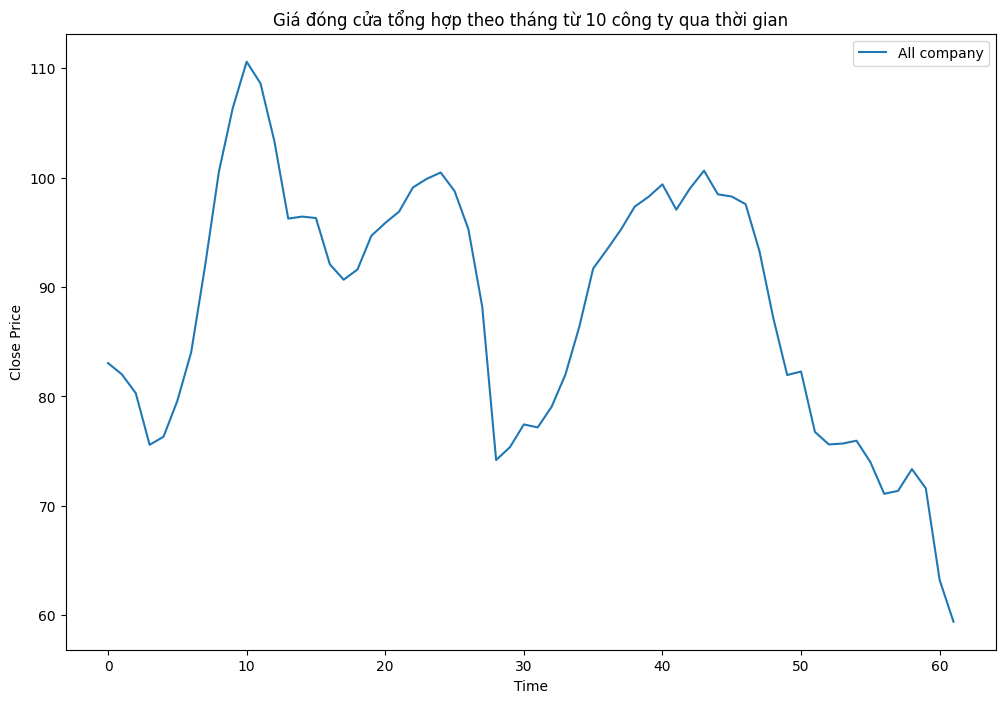

In [31]:
plt.figure(figsize=(12,8))
plt.title("Giá đóng cửa tổng hợp theo tháng từ 10 công ty qua thời gian")

plt.plot(df_combined.index, df_combined['close_total4week'], label="All company")

plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()

#ARIMA Model

In [32]:
total = df_combined['close_total4week']
trend_data = df_combined['trend']
d = ndiffs(total, test="adf")
print("Tính toán bậc sai phân của chuỗi giá đóng:", d)

Tính toán bậc sai phân của chuỗi giá đóng: 1


In [33]:
close_diff = total.diff().dropna()

<Figure size 1800x600 with 0 Axes>

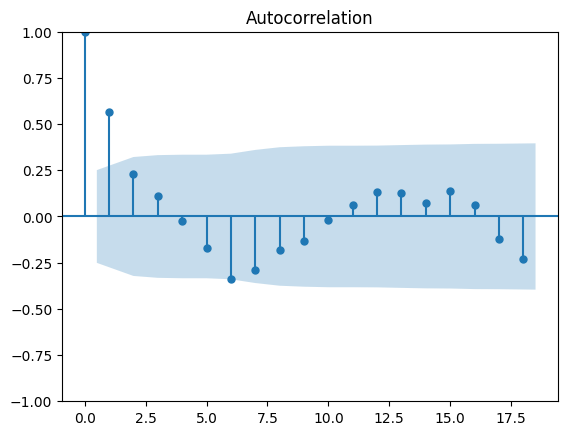

In [34]:
plt.figure(figsize = (18,6))
ax = plot_acf(close_diff)
plt.title("Autocorrelation")
plt.show()

<Figure size 1800x600 with 0 Axes>

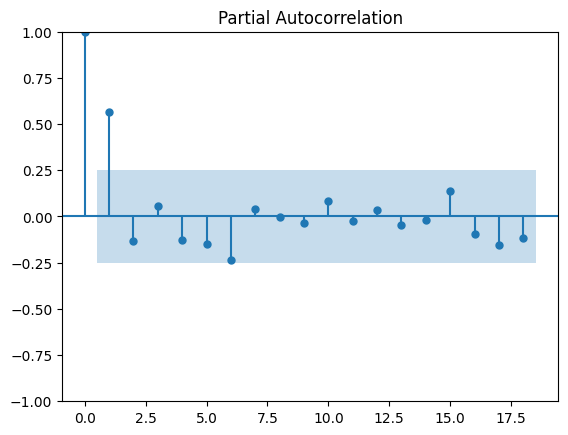

In [35]:
plt.figure(figsize = (18,6))
ax = plot_pacf(close_diff)
plt.title("Partial Autocorrelation")
plt.show()

In [36]:
train_len = int(len(total)*0.8)
train_data = total[:train_len]
test_data = total[train_len:]
trend_test = trend_data[train_len:]

In [37]:
print('Train data: ', len(train_data))
print('Test data: ', len(test_data))
print('Trend test data:', len(trend_test))

Train data:  49
Test data:  13
Trend test data: 13


In [59]:
model = ARIMA(train_data, order=(5,1,4))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:       close_total4week   No. Observations:                   49
Model:                 ARIMA(5, 1, 4)   Log Likelihood                -118.186
Date:                Tue, 12 Mar 2024   AIC                            256.372
Time:                        20:31:00   BIC                            275.084
Sample:                             0   HQIC                           263.444
                                 - 49                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5805      0.393      4.020      0.000       0.810       2.351
ar.L2         -0.7389      0.922     -0.802      0.423      -2.546       1.068
ar.L3         -0.6575      0.943     -0.698      0.4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


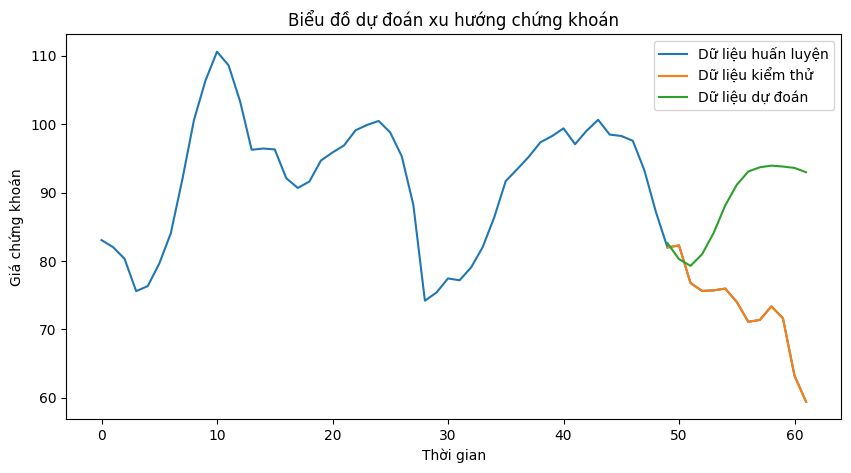

In [60]:
predict = result.get_forecast(len(test_data))
price_values = predict.predicted_mean.values
conf = predict.conf_int(alpha=0.05)
predict_series = pd.Series(price_values, index=test_data.index.values)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(total, label="Dữ liệu huấn luyện")
plt.plot(test_data, label="Dữ liệu kiểm thử")
plt.plot(predict_series, label="Dữ liệu dự đoán")

plt.title('Biểu đồ dự đoán xu hướng chứng khoán')
plt.xlabel('Thời gian')
plt.ylabel('Giá chứng khoán')
plt.legend()
plt.show()

In [61]:
a = predict_series
index = pd.to_datetime(train_data.index.values[-1])
b = pd.Series(train_data.iloc[-1], index=[index])
predict = pd.concat([b,a])
predict = predict[1:]
trend_predict = predict.pct_change()*100 > 0
trend_predict = (trend_predict.iloc[:] > 0).astype(int).values
accuracy = accuracy_score(trend_predict, trend_test)
print(f"Accuracy: {accuracy: .2f}")

Accuracy:  0.62


#The End